In [1]:
import boto3
import sagemaker
import cv2

In [2]:
cv2.__version__

'4.5.1'

In [2]:
print(boto3.__version__)
print(sagemaker.__version__)

1.17.39
2.32.0


In [3]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
print(bucket)
print(role)

sagemaker-us-east-2-805291263703
arn:aws:iam::805291263703:role/service-role/AmazonSageMaker-ExecutionRole-20200826T145400


In [4]:
prefix = 'pytorch-dogscats'
model_path = sess.upload_data('./jit.tar.gz', bucket=bucket, key_prefix=prefix)
print(model_path)

s3://sagemaker-us-east-2-805291263703/pytorch-dogscats/jit.tar.gz


# Create model, endpoint configuration and endpoint

In [5]:
import time

In [7]:
sm = boto3.client('sagemaker')

In [15]:
model_name = prefix + '-' + time.strftime('%Y-%m-%d-%H-%M-%S', time.gmtime())
print(model_name)

pytorch-dogscats-2021-04-01-03-02-03


In [16]:
response = sm.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    Containers = [
        {
            'Image': '763104351884.dkr.ecr.us-east-2.amazonaws.com/pytorch-inference:1.5-cpu-py3',
            'ModelDataUrl': 's3://{}/{}/jit.tar.gz'.format(bucket, prefix),
            'Mode': 'SingleModel',
            'Environment': {
                'SAGEMAKER_PROGRAM': 'inference_pt.py',
                'SAGEMAKER_SUBMIT_DIRECTORY': '/opt/ml/model/code',
                'SAGEMAKER_CONTAINER_LOG_LEVEL': '20',
                'SAGEMAKER_REGION': 'us-east-2',
                'MMS_DEFAULT_RESPONSE_TIMEOUT': '500'
            }
        }
    ]
)
print(response)

{'ModelArn': 'arn:aws:sagemaker:us-east-2:805291263703:model/pytorch-dogscats-2021-04-01-03-02-03', 'ResponseMetadata': {'RequestId': '77fe6f7d-ed38-40be-9a38-e002152d95d9', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '77fe6f7d-ed38-40be-9a38-e002152d95d9', 'content-type': 'application/x-amz-json-1.1', 'content-length': '98', 'date': 'Thu, 01 Apr 2021 03:02:08 GMT'}, 'RetryAttempts': 0}}


In [17]:
epc_name = prefix + '-epc-' + time.strftime('%Y-%m-%d-%H-%M-%S', time.gmtime())
print(epc_name)

pytorch-dogscats-epc-2021-04-01-03-02-11


In [18]:
response = sm.create_endpoint_config(
    EndpointConfigName = epc_name,
    ProductionVariants = [
        {
            'VariantName': 'variant-1',
            'ModelName': model_name,
            'InitialInstanceCount': 1,
            'InstanceType': 'ml.m5.large',
            'InitialVariantWeight': 1
        }
    ]
)
print(response)

{'EndpointConfigArn': 'arn:aws:sagemaker:us-east-2:805291263703:endpoint-config/pytorch-dogscats-epc-2021-04-01-03-02-11', 'ResponseMetadata': {'RequestId': '666816e0-11fa-4e8e-9ad0-16ffd75fe3c6', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '666816e0-11fa-4e8e-9ad0-16ffd75fe3c6', 'content-type': 'application/x-amz-json-1.1', 'content-length': '121', 'date': 'Thu, 01 Apr 2021 03:02:12 GMT'}, 'RetryAttempts': 0}}


In [19]:
ep_name = prefix + '-ep-' + time.strftime('%Y-%m-%d-%H-%M-%S', time.gmtime())
print(ep_name)

pytorch-dogscats-ep-2021-04-01-03-02-14


In [20]:
response = sm.create_endpoint(
    EndpointName = ep_name,
    EndpointConfigName = epc_name
)
print(response)

{'EndpointArn': 'arn:aws:sagemaker:us-east-2:805291263703:endpoint/pytorch-dogscats-ep-2021-04-01-03-02-14', 'ResponseMetadata': {'RequestId': '9541937d-458f-47f2-8d23-b4fee35a5802', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '9541937d-458f-47f2-8d23-b4fee35a5802', 'content-type': 'application/x-amz-json-1.1', 'content-length': '107', 'date': 'Thu, 01 Apr 2021 03:02:15 GMT'}, 'RetryAttempts': 0}}


In [21]:
sm.describe_endpoint(EndpointName=ep_name)

{'EndpointName': 'pytorch-dogscats-ep-2021-04-01-03-02-14',
 'EndpointArn': 'arn:aws:sagemaker:us-east-2:805291263703:endpoint/pytorch-dogscats-ep-2021-04-01-03-02-14',
 'EndpointConfigName': 'pytorch-dogscats-epc-2021-04-01-03-02-11',
 'EndpointStatus': 'Creating',
 'CreationTime': datetime.datetime(2021, 4, 1, 3, 2, 15, 458000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2021, 4, 1, 3, 2, 15, 458000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '7d4802d1-e63c-4a55-a9b5-f8934bed2458',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '7d4802d1-e63c-4a55-a9b5-f8934bed2458',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '324',
   'date': 'Thu, 01 Apr 2021 03:02:16 GMT'},
  'RetryAttempts': 0}}

In [22]:
waiter = sm.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=ep_name)

# Inference

In [28]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch
from io import BytesIO
import numpy as np

In [24]:
TEST_DIR = './test1'

In [25]:
test_imgs = os.listdir(TEST_DIR)

In [26]:
smrt = boto3.client('sagemaker-runtime')

b'[[0.4264960289001465]]'


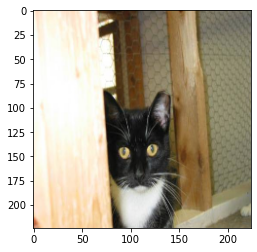

b'[[0.5758395195007324]]'


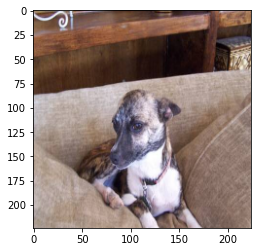

b'[[0.6121008396148682]]'


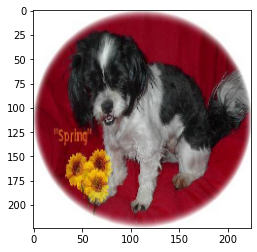

b'[[0.5735995173454285]]'


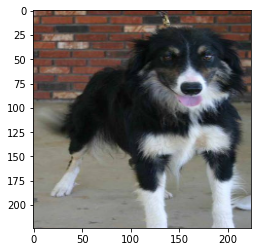

b'[[0.5444851517677307]]'


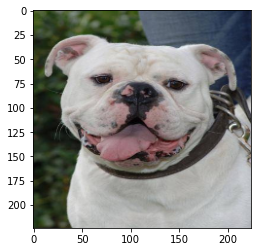

b'[[0.40677139163017273]]'


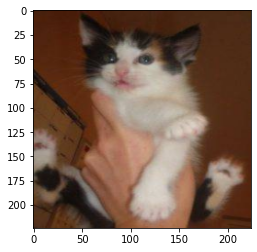

b'[[0.5372095108032227]]'


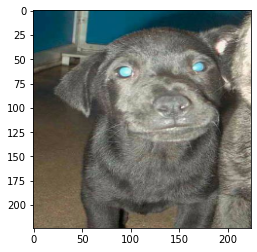

b'[[0.49896353483200073]]'


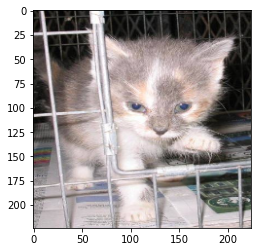

b'[[0.41478291153907776]]'


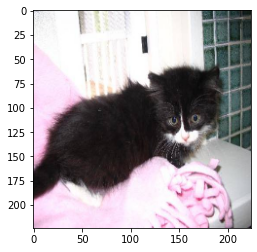

b'[[0.6317309141159058]]'


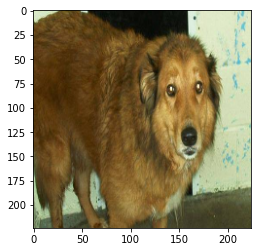

In [30]:
for i in range(10):
    im = cv2.imread(os.path.join(TEST_DIR, test_imgs[i]))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (224,224))
    tensor_x = np.expand_dims(im, axis=0)
    tensor_x = tensor_x.transpose((0,3,1,2))
    buffer = BytesIO()
    np.save(buffer, tensor_x)
    
    response = smrt.invoke_endpoint(
        EndpointName=ep_name,
        Body=buffer.getvalue(),
        ContentType='application/x-npy'
    )
    print(response['Body'].read())
    plt.imshow(im)
    plt.show()

# Delete model, endpoint configuration and endpoint

In [31]:
sm.delete_endpoint(EndpointName=ep_name)

{'ResponseMetadata': {'RequestId': 'a38760f7-53d9-4c67-8fea-c18bbb494ee5',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'a38760f7-53d9-4c67-8fea-c18bbb494ee5',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Thu, 01 Apr 2021 03:15:27 GMT'},
  'RetryAttempts': 0}}

In [32]:
sm.delete_endpoint_config(EndpointConfigName=epc_name)

{'ResponseMetadata': {'RequestId': '98381d21-1f12-488a-a462-09d9e6cf87b9',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '98381d21-1f12-488a-a462-09d9e6cf87b9',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Thu, 01 Apr 2021 03:15:42 GMT'},
  'RetryAttempts': 0}}

In [33]:
sm.delete_model(ModelName=model_name)

{'ResponseMetadata': {'RequestId': '29951f8a-256d-41c2-abf4-77236128008c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '29951f8a-256d-41c2-abf4-77236128008c',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Thu, 01 Apr 2021 03:15:50 GMT'},
  'RetryAttempts': 0}}